# WAW ML5 Tutorial - Hyperparameter Optimization - Part 2

<img src='https://raw.githubusercontent.com/DLR-SC/Hyperparameter_tutorial/master/img/WAW_Tutorial_Title.png' width=500px>


In [22]:
%matplotlib inline
import talos
import numpy as np

## Overview

The aim of the 2nd tutorial is the following:

* Introduction of Talos
* Use Talos for machine-assisted hyperparameter optimization of the Boston house price problem (1st Jupyter notebook)
* Give general guidelines for hyperparamter optimization

## 1. Introduction of Talos <a name="one"></a> 

### Start (iteration 0) with the original Keras code 

We first start with the code that we have already used in the first notebook

In [2]:
from keras.datasets import boston_housing

# load the data
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

# data normalization
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### Model preparation

Talos works with any Keras model, without changing the structure of the model in any way.  
The only difference in the Keras model is that a parameter is not set explicitly as before, e.g.

<pre><code> model.add(layers.Dense(32, activation='relu'))    </code></pre>

but instead taken from a dictionary, e.g.

<pre><code>
params = {'number_of_neurons' : [4, 6, 7, 8], 'activation' : ['relu'] }

model.add(layers.Dense(params['number_of_neurons'], activation=params['activation']))    
</code></pre>

Afterwards, this dictionary and the model will be passed to Talos. In the dictionary we have 
three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

For values we don't want to use, it's ok to set it as None.

NOTE: at this point you have to import from Keras the optimizer, activations, and losses you want to scan for.

## Tasks ## 
__Excercise 1:__
 - Create a Python dictionary that contains at least the following entries:
    * 'number_of_layers' : 1, 2
    * 'number_of_neurons' : 8, 16, 32, 64
    * 'dropout_value' : None, 0.1, 0.2
    * 'optimizer' : 'Adam', 'rmsprop'
    * 'batch_size': 1, 2, 4, 8 
    * 'epoch_number' : 10, 20, 40, 80
    * anything that you want to modify further (e.g. learning_rate, activation_function, loss_function, ...)
 - What is the number of different hyperparameter configurations that is considered?

In [3]:
# parameter dictionary
param = {'number_of_layers' : [1, 2],
         'number_of_neurons' : [8, 16, 32, 64],
         'epoch_number' : [10, 20, 40, 80],
         'dropout_value' : [None, 0.1, 0.2],
         'optimizer' : ['Adam', 'rmsprop'],
         'batch_size' : [1, 2, 4, 8]}


## Tasks ## 
__Excercise 2:__
 - Modify your original Keras model (Jupyter notebook 1) such that it uses uses the values from a 
 dictionary 'p'.

In [4]:
from keras import models
from keras import layers

def build_better_model(train_data, train_targets, val_data, val_targets, p):
    model = models.Sequential()
    
    # replace the hyperparameter inputs with references to dictionary p 
    model.add(layers.Dense(p['number_of_neurons'], activation='relu',
                           input_shape=(train_data.shape[1],)))
    
    if p['number_of_layers'] >= 2:
        model.add(layers.Dense(p['number_of_neurons'], activation='relu'))
    
    if p['dropout_value'] is not None:
        model.add(layers.Dropout(p['dropout_value']))
        
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    
    # make sure history object is returned by model.fit()
    history = model.fit(train_data, train_targets, epochs=p['epoch_number'], batch_size=p['batch_size'], verbose=0)
    
    return history, model

## 2. Use Talos for hyperparameter optimization <a name="two"></a> 

This part is quite simple. The Talos experiment just uses the <code> Scan()<\code> command. In the following,
we will investigate different arguments for this routine. However, it there are only four necessary arguments
that are required:
* train_data (often known as 'x')
* train_targets (often known as 'y')
* params (the dictionary 'param' that we have created before)
* model (the 'build_model' that we also have created before)

In [5]:
scan_object = talos.Scan(x=train_data,
                         y=train_targets,
                         model=build_better_model,
                         experiment_name='find_optimal_params',
                         params=param,
                         round_limit=10)

100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


If all different parameter configurations from the dictionary are used, the routine <code> Scan()</code> has to
evaluate 768 different models. Depending on the neural network architecture and the number of training samples,
this can be very time consuming.

As a solution, Talos offers several routines to limit the number of model configurations that is evaluated. Two useful
commands of <code> Scan()</code> for this purpose are:

* <code> round_limit=10</code> which limits the number of model evaluations to the specified integer value (e.g. 
10 model evaluations in this example).
* <code> fraction_limit = 0.1</code> specifies the fraction of `params` that will be tested  (e.g. 10% of the 
configurations in this example).   

### Access the results through the <code>Scan</code> object 

Using <code> round_limit=10</code> we have actually investigated only ten parameter configurations (since the time
for this tutorial is limited). But how do I get the ten configurations that have been used and what is their
performance?

For this purpose, the results of the scan object can be directly accessed:

In [6]:
# accessing the results data frame
scan_object.data


,round_epochs,loss,mae,batch_size,dropout_value,epoch_number,number_of_layers,number_of_neurons,optimizer
0,10,173.413228,11.236574,8,0.1,10,1,32,Adam
1,40,14.938728,2.862601,2,0.2,40,2,32,rmsprop
2,10,24.192568,3.609028,2,0.1,10,2,16,rmsprop
3,80,33.016906,4.234593,4,0.2,80,1,16,rmsprop
4,20,112.600002,8.253620,8,0.2,20,1,8,rmsprop
5,10,23.136458,3.445873,4,0.1,10,2,32,Adam
6,10,26.904475,3.739406,1,0.1,10,1,16,rmsprop
7,20,27.768293,3.840090,4,0.1,20,1,32,Adam
8,10,42.682594,4.920127,1,0.2,10,2,8,Adam
9,20,40.555902,4.778998,8,0.1,20,2,8,rmsprop


The output on my local computer is (the results should differ on your machine since you 
consider ten other parameter configurations which we will explain later on)

<img src='https://raw.githubusercontent.com/DLR-SC/Hyperparameter_tutorial/master/img/talos_scan_output.png' 
width=1000px>

There are several hyperparameter configurations with a mean average error (mae) in the range 2-3.
Since the number of training samples is only 400, the result of the mean average error 
have a high variance and should not be overestimated. Nevertheless, the we already obtain a certain 
intuition on the size of some of the hyperparameters (e.g. 10 epochs is certainly not
 enough since 'mae' becomes large then).
 

You already noticed that your results differ from mine. This is due to the usage of a 'random search'
strategy in Talos. More information on the search strategy are given 
in the summary details using <code>scan_object.details</code>.  

In [7]:
# access the summary details
scan_object.details


experiment_name        find_optimal_params
random_method             uniform_mersenne
reduction_method                      None
reduction_interval                      50
reduction_window                        20
reduction_threshold                    0.2
reduction_metric                   val_acc
complete_time               11/19/19/11:01
x_shape                          (404, 13)
y_shape                             (404,)
dtype: object

From the 768 possible hyperparameter configurations Talos considers a random subset
of ten configurations (due to <code>round_limit=10</code>). This random subset 
is chosen with a 'Mersenne Twister' pseudorandom number generator. Other possible
random choices are e.g. 'Halton' or 'Sobol' quasi Monte Carlo sequences. 

Note: If there is no parameter such as  <code> round_limit=10</code> or
<code> fraction_limit = 0.1</code> the default optimization strategy 
is called 'grid search'. This means that all hyperparameter permutations in 
a given dictionary are processed. In most cases, this is not recommended
for anything but very small permutation spaces. 
Therefore, better use a 'random search' routine.

In addition to statistics and meta-data related with the Scan, the used data (x and y) 
together with the saved model and model weights for each hyperparameter permutation is stored in the Scan object. 

In [13]:
# accessing the saved models which returns a list of models
scan_object.saved_models

# accessing the saved weights for models which returns a list of weights
model_weights = scan_object.saved_weights

# weights of first model 
model_weights[0]

[array([[-8.38897407e-01, -1.43938139e-01,  1.11391522e-01,
         -1.09193353e-02,  2.58457959e-01,  2.17029408e-01,
         -2.04411387e-01, -8.21907043e-01, -2.64130056e-01,
         -6.01866804e-02, -7.31536001e-02, -1.39986232e-01,
          4.16413635e-01, -5.20827956e-02,  5.98771423e-02,
          4.12954122e-01,  2.31539115e-01,  1.11565955e-01,
          2.63870001e-01, -2.02329814e-01, -2.50781149e-01,
          2.32718915e-01, -5.56486659e-02,  1.35042012e-01,
         -3.68533343e-01,  7.01688975e-02,  2.37694308e-01,
         -2.54949778e-01, -2.98739910e-01, -2.88264781e-01,
          8.69323611e-02,  2.34808996e-01],
        [-1.24940433e-01, -1.07590645e-03, -2.83617735e-01,
          2.80249089e-01,  1.20290406e-01,  2.57741481e-01,
         -2.87064195e-01, -1.31497920e-01, -3.32656838e-02,
         -2.66632348e-01,  2.29115617e-02,  1.90930948e-01,
         -1.74275011e-01, -2.16409728e-01,  2.39052877e-01,
          1.47082329e-01, -1.37673736e-01, -1.60397105e-

The Scan object can be further used, and is required, as input for Predict(), Evaluate(), and Deploy(). 
More about this in the corresponding sections below.

### Analysing the Scan results with <code>Reporting()</code> 

In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the 
present working directory (which is './find_optimal_params' our case). The Reporting() 
accepts as its source either a file name, or the Scan object. 

In [8]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

In [9]:
# get the number of rounds in the Scan
analyze_object.rounds()

10

In [10]:
# get the lowest result for any metric (if lower is better)
analyze_object.low('mae')

2.8626010417938232

Next, we want to obtain the parameters of our best n=3 parameter runs. For this
purpose we use <code> best_params</code>. It is alluring to consider the best 
result only (i.e. n=1 in the following cell) but keep in mind that due to the high
variance in the result, a sequence of more models should be considered.

The signature of <code> best_params</code> is the following:
* The first argument (here 'mae') is the metric that is considered.
* The second argument is a list of metrics / loss functions that is not required here
* The third argument gives the 'n' best results
* Fourth argument: ascending | bool | Set to True when `metric` is to be minimized eg. loss or mae

In [11]:
# get the best n=3 paramaters
analyze_object.best_params('mae', ['loss'], n=3, ascending=True)

array([[0.2, 2, 2, 32, 40, 'rmsprop', 40, 0],
       [0.1, 4, 2, 32, 10, 'Adam', 10, 1],
       [0.1, 2, 2, 16, 10, 'rmsprop', 10, 2]], dtype=object)

It is very important to determine which of your hyperparameter has the largest impact on 
your performance metric. These are the parameters that should be further investigated. 

One solution to achive this is to compute the linear correlation between your performance metric
'mae' and your hyperparamters. The correlation coefficient is +1 in the case of a perfect direct
(increasing) linear relationship, -1 in the case of a perfect decreasing (inverse) linear 
relationship and some values in (-1, 1) otherwise (indicating the degree of linear dependance
between the variables).

We employ <code> correlate()</code> for computing the correlation

In [12]:
# get correlation for hyperparameters against a performance metric such as 'mae' (we exclude 'loss' since 
# this is not a hyperparameter)
analyze_object.correlate('mae', ['loss', 'round_epochs'])

batch_size           0.710765
dropout_value       -0.007994
epoch_number        -0.212363
number_of_layers    -0.469804
number_of_neurons   -0.020119
Name: mae, dtype: float64

Since you have only then different hyperparameter runs, the output is almost random. However, in practice 
with hundreds or thousand of different configurations the result is valuable to find the important hyperparameters.

<img src='https://raw.githubusercontent.com/DLR-SC/Hyperparameter_tutorial/master/img/talos_correlate.png' 
width=240px>

so (im my special case) 'epoch_number' and 'number_of_neurons' have the strongest inverse effect on 'mae'
(i.e. something like 'more epochs leads to a lower mean average error'). The 'batch_size' seems to be less important. 

You can also plot a heatmap of this correlation using <code> plot_corr()</code>:

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


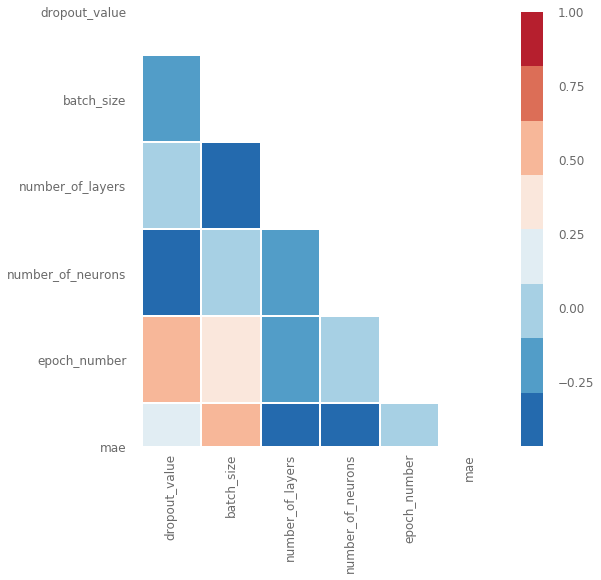

In [13]:
# heatmap correlation
analyze_object.plot_corr('mae', ['loss', 'round_epochs'])

The correlation between variables in one viable way to find the most important
hyperparameters. A different approach is given by <code> plot_bars()</code>.
Using this function, the metric 'mae' is plotted for different values of the 
hyperparameters 'number_of_neurons', 'number_of_layers' and 'epoch_number'. As mentioned
before, 'mae' seems to decrease for larger values of these hyperparameters (in the
specified region of the dictionary).

The bar grid has error bars if there is more than one result for the specified
three hyperparameters 'number_of_neurons', 'epoch_number' and 'number_of_layers'. 

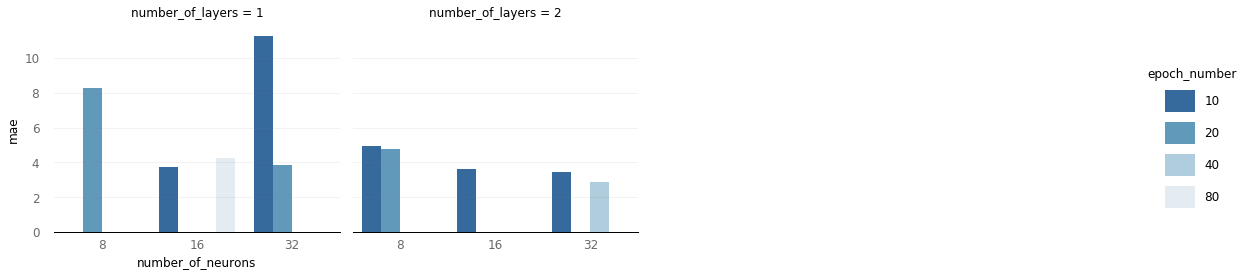

In [14]:
# a four dimensional bar grid
analyze_object.plot_bars('number_of_neurons','mae', 'epoch_number', 'number_of_layers')

My output plot is

<img src='https://raw.githubusercontent.com/DLR-SC/Hyperparameter_tutorial/master/img/talos_bar.png' 
width=1300px>

## Tasks ## 
__Excercise 3:__
 - Apply the described process to your Talos output. Im more details:
    * Find the hyperparameters that have the strongest effect on the performance metric.
    * Create a 2nd hyperparameter dictionary that further investigates the important hyperparameters
    * Use <code> Scan() </code> to investigate the 2nd dictionary in more detail 
    (use larger values for round_limit than 10).
    * Try to find a close-to-optimal model for this specific regression problem. 

In [15]:
# your new hyperparameter dictionary
param2 = {'number_of_layers' : [1, 2],
         'number_of_neurons' : [8, 16, 32, 64],
         'epoch_number' : [10, 20, 40, 80],
         'dropout_value' : [0.1],
         'optimizer' : ['Adam'],
         'batch_size' : [2]}

In [16]:
scan_object2 = talos.Scan(x=train_data,
                         y=train_targets,
                         model=build_better_model,
                         experiment_name='find_optimal_params',
                         params=param2,
                         round_limit=30)

100%|██████████| 30/30 [03:33<00:00,  7.10s/it]


In [52]:
scan_object2.data

,round_epochs,loss,mae,batch_size,dropout_value,epoch_number,number_of_layers,number_of_neurons,optimizer
0,40,11.457275,2.374314,2,0.1,40,2,32,Adam
1,80,11.027953,2.529704,2,0.1,80,1,32,Adam
2,40,18.879210,3.145980,2,0.1,40,2,16,Adam
3,10,21.524335,3.074557,2,0.1,10,2,32,Adam
4,80,6.054606,1.890788,2,0.1,80,2,64,Adam
5,20,12.424296,2.593658,2,0.1,20,2,32,Adam
6,10,36.311936,4.087215,2,0.1,10,1,32,Adam
7,80,27.776842,3.539782,2,0.1,80,1,8,Adam
8,10,26.009413,3.719249,2,0.1,10,2,16,Adam
9,20,31.270360,4.182493,2,0.1,20,1,16,Adam


Your best results are:

In [17]:
# use Scan object as input
analyze_object2 = talos.Analyze(scan_object2)

# get the best n=3 paramaters
analyze_object2.best_params('mae', ['loss'], n=3, ascending=True)

array([[0.1, 2, 2, 64, 80, 'Adam', 80, 0],
       [0.1, 2, 2, 64, 40, 'Adam', 40, 1],
       [0.1, 2, 2, 64, 20, 'Adam', 20, 2]], dtype=object)

In [18]:
# lowest mae with the parameters from analyze_object2.best_params('mae', ['loss'], n=1, ascending=True)
analyze_object2.low('mae')

1.890788197517395

## Deploy close-to-optimal model

### Evaluating Models with <code>Evaluate()</code> 

Models can be evaluated with <code>Evaluate()</code> against a k-fold cross-validation 
(<code>fold=K</code> specifies the number of repetitions in <code>Evaluate()</code>). 
Ideally at least 50% of the data, or more if possible, is kept completely out of the <code>Scan</code> process and only exposed into Evaluate once one or more candidate models have been identified.

In [23]:
evaluate_object = talos.Evaluate(scan_object2)

# returns a list with 'folds=10' outputs
all_mae_results =  evaluate_object.evaluate(test_data, test_targets, folds=10, metric='mae', task='continuous')

# this is the average 'mae' that gives an aedequate estimation of our model error (on the test data)
np.mean(all_mae_results)

5.813494976043701

Once a sufficiently performing model have been found, a deployment package can be easily created.

### Deploying Models with <code>Deploy()</code> 

Once the right model or models have been found, you can create a deployment package with <code>Deploy()</code> which is then easy to transfer to a production or other environment, send via email, or upload to shared remote location. Best model is automatically chosen based on a given metric ('val_acc' by default).

The Deploy package is a zip file that consist of: 

- details of the scan
- model weights
- model json
- results of the experiment
- sample of x data
- sample of y data

The <code>Deploy</code> package can be easily restored with <code>Restore()</code> which is covered in the next section.

In [57]:
# creates a file waw_regression_deploy.zip (\approx 13 KB) in the local folder 
# the parameter 'asc' has to be true if lower means better (e.g. loss, mae) but false otherwise (e.g. accuracy)
talos.Deploy(scan_object=scan_object2, model_name='waw_regression_deploy', metric='mae', asc=True);

Deploy package waw_regression_deploy have been saved.


### Restoring Models with <code>Restore()</code>  

In [58]:
waw_regression = talos.Restore('waw_regression_deploy.zip')

The <code>Restore</code> object now consists of the assets from the Scan object originally associated with the experiment, together with the model that had been picked as 'best'. The model can be immediately used for making prediction, or use in any other other way Keras model objects can be used.

In [59]:
# What is the 'best' model that we use for predictions?
# this should be the same model as in 
# 'analyze_object2.best_params('mae', ['loss'], n=1, ascending=True)' from the previous cell 
waw_regression.model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 13),
    'dtype': 'float32',
    'units': 64,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 64,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {

In [60]:
# make predictions with the model
# if you are interested, compare the output with the ground truth 'test_targets'
waw_regression.model.predict(test_data)

array([[ 8.197606 ],
       [20.49187  ],
       [21.705572 ],
       [33.281807 ],
       [24.841562 ],
       [20.987709 ],
       [25.923063 ],
       [19.832514 ],
       [19.9093   ],
       [24.510082 ],
       [17.64567  ],
       [18.076717 ],
       [15.686621 ],
       [41.736397 ],
       [20.328083 ],
       [20.224676 ],
       [25.171272 ],
       [18.35801  ],
       [21.267384 ],
       [24.090937 ],
       [13.295918 ],
       [13.419363 ],
       [21.448696 ],
       [15.651767 ],
       [18.619667 ],
       [28.453379 ],
       [30.033508 ],
       [30.809359 ],
       [11.596068 ],
       [19.085573 ],
       [19.672104 ],
       [14.941357 ],
       [31.070314 ],
       [24.013067 ],
       [17.386688 ],
       [11.310868 ],
       [15.532573 ],
       [20.087654 ],
       [21.32449  ],
       [23.703724 ],
       [30.09648  ],
       [26.680552 ],
       [14.10518  ],
       [42.260494 ],
       [30.563845 ],
       [26.099182 ],
       [27.012655 ],
       [18.04

In addition, for book keeping purpose, and for simplicity of sharing models with team members and other stakeholders, various attributes are included in the <code>Restore</code> object:

In [29]:
# get the meta-data for the experiment
waw_regression.details

,0,1
0,experiment_name,find_optimal_params
1,random_method,uniform_mersenne
2,reduction_method,NaN
3,reduction_interval,50
4,reduction_window,20
5,reduction_threshold,0.2
6,reduction_metric,val_acc
7,complete_time,11/19/19/11:09
8,x_shape,"(404, 13)"
9,y_shape,"(404,)"


In [31]:
# get the hyperparameter space boundary, these are the hyperparameter values that you have considered before
waw_regression.params


{'number_of_layers': [1, 2],
 'number_of_neurons': [8, 16, 32, 64],
 'epoch_number': [10, 20, 40, 80],
 'dropout_value': [0.1],
 'optimizer': ['Adam'],
 'batch_size': [2]}

In [62]:
# these are the results from the different runs of Scan()
waw_regression.results

,round_epochs,loss,mae,batch_size,dropout_value,epoch_number,number_of_layers,number_of_neurons,optimizer
0,40,11.457275,2.374314,2,0.1,40,2,32,Adam
1,80,11.027953,2.529704,2,0.1,80,1,32,Adam
2,40,18.879210,3.145980,2,0.1,40,2,16,Adam
3,10,21.524335,3.074557,2,0.1,10,2,32,Adam
4,80,6.054606,1.890788,2,0.1,80,2,64,Adam
5,20,12.424296,2.593658,2,0.1,20,2,32,Adam
6,10,36.311936,4.087215,2,0.1,10,1,32,Adam
7,80,27.776842,3.539782,2,0.1,80,1,8,Adam
8,10,26.009413,3.719249,2,0.1,10,2,16,Adam
9,20,31.270360,4.182493,2,0.1,20,1,16,Adam


That's all on Talos for today. Of course, there are several other routines that are provided by Talos. You find
the most recent version on GitHub (https://github.com/autonomio/talos).  

### Final comments on hyperparameter optimization:

* Hyperparameter optimization (at least as described in this tutorial) is an iterative process. You define the
hyperparamter boundaries and start a search (with <code>Scan()</code>). Using the results, you define new
hyperparameter boundaries and a second search, ...
* It is important to determine those hyperparameter that have the largest influence on your performance
metric. Talos routine such as <code>correlatie()</code> assist you to find these hyperparameters.
* All different hyperparameter combinations are evaluated on a validation set. As usual, your final (after several iterations)
model is evaluated with a test set that is independet of the validation set.
* Even though Talos can be used analyze to thousand of hyperparameter configurations it is important to
first have some kind of intuition which model architecture might be adequate (e.g. do you require 
fully connected neural networks, convolutional neural networks, what might be the rough number
of hidden layers?). Otherwise, since the hyperparameter space grows exponentially you will not be able 
to evaluate a relevant subset within a reasonable amount of time.


Thank you for your participiation! <br>
We hope that you have enjoyed this tutorial.

Best regards, <br>
Charlotte Debus <br>
Alexander Rüttgers